In [1]:
import numpy as np
from PIL import Image
from sklearn.ensemble import RandomForestClassifier
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import random
from matplotlib import animation
import matplotlib.animation as animation
%matplotlib notebook
np.set_printoptions(precision=3)
random.seed(1)

# GIBBS SAMPLING IN CONDITIONAL RANDOM FIELDS
### Loic Landrieu, 2019

We consider an image $I$ whose structure is given by the graph $(V,E)$ where $V$ is the set of pixels and $E \subset V \times V$ encodes their adjacency.

We want to retrieve a binary latent variable $Z \rightarrow \{0,1\}^V$ for each pixel. We have an observation $x \in \mathbb{\Omega}^V$ with $\Omega \subset \mathbb{R}^d$, related to the unobserved latent variable. However, we also know that the latent variable is spatially regular over the image.

To implement this prior, we model the random variable $Z$ as a conditional random field (CRF), which is a discriminative undirected graphical model.

<img src="CRF.png" alt="CRF" style="width: 200px;"/>

This model can be described by an Ising model:
$$
p(z \mid x ; \eta) = \exp\left(\sum_{i \in V} \eta_{i}z_i + \sum_{(i,j) \in E} \eta_{i,j}z_i z_j\right)~,
$$
with $\eta$ defined as follows:

$$
\eta_{i,j} = 4 \lambda,
$$
and
$$
\eta_i = \log\left( \frac{{q}_i}{1-{q}_i} \right) - 2 \lambda \mid N_i \mid,
$$
where $N_i$ denotes the set of pixel neighboring $i$, $\lambda\in\mathbb{R}$ is the regularization strength, and $q_i = p(z_i=1 \mid x_i)$.

In practice , we regularize $q$ to prevent numerical issues
$$
\hat{q_i} = (1-\alpha) q_i + \frac\alpha2
$$



Q1: Complete the following function which takes as input an array $\left( \pi_i \right)_{i \in V}$  of probabilities : $\pi_i = p(Y_i=1)$ for an unspecified random variable $Y$, and a regularizing parameter $\alpha$ and returns the array $\left(\hat{\pi}_i \right)_{i \in V}$
with $\hat{\pi}_i = (1-\alpha) \pi_i + \frac\alpha2$.

In [2]:
def regularize(pis, alpha):
    return pis * ( 1 - alpha) + alpha / 2

Q2 In pratical applications probabilities $q_i$ are computed from the observations by another model. Here set them by hand in the cell below.


What can we expect the marginals $p(z_i = 1\mid x)$ to be like if $\lambda$ is high? Low? Extremely high?

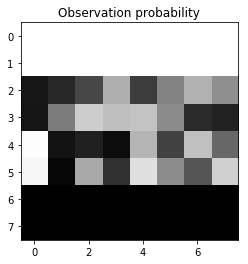

In [3]:
proba = np.random.rand(8,8)
proba[0:2,:] = 0
proba[-2:,:] = 1
plt.figure()
plt.imshow(proba)
plt.set_cmap('binary')
plt.title('Observation probability')
plt.show()

In [4]:
high: high regularity, middle either black or white. low : some noise remaining. very high : grey.

SyntaxError: invalid syntax (<ipython-input-4-0e039f89e861>, line 1)

Q3: complete the following function to compute the unary potentials $\eta_i$.

Visualize the image of unaries and make sure it makes sense.

In [5]:
def compute_unary(proba, reg_strength):
    n_lin = proba.shape[0]
    n_col = proba.shape[1]
    n_nei = np.zeros((n_lin,n_col))
    unary = np.zeros((n_lin,n_col))
    
    #count the neighbours
    n_nei[1:,:] += 1
    n_nei[:-1,:] += 1
    n_nei[:,1:] += 1
    n_nei[:,:-1] += 1

    smoothed_proba = regularize(proba, 0.05)#regularized version of proba

    return np.log(smoothed_proba / (1 - smoothed_proba)) - 2 * reg_strength * n_nei

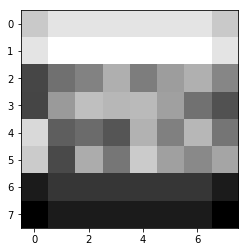

In [6]:
plt.figure()
plt.imshow(compute_unary(proba, .5))
plt.show()

We use the Gibbs sampling algorithm to compute the pixel marginals of $X$ : $p(z_{i}=1\mid x;\eta)$.

$z^{(0)} \leftarrow \;\texttt{random initialization}$

$\texttt{for t = 1 to max_ite_gibbs:}$

$\quad i\leftarrow \texttt{random pixel}$
    
$\quad \texttt{sample}\; z^{(t)}_i\; \texttt{from}\; p(z_{i}\mid z^{(t-1)},x;\eta)$

$\quad z_{i}^{(t)} \leftarrow  z_{i}^{(t-1)}$

After enough iteration, we have:

$$p(z_{i}=1\mid x;\eta) \approx \frac1{T-T_0}\sum_{t = T_0}^T z_{i}^{(t)}.$$

Note: in the Ising model, we have:

$$
p(z_{i}=1\mid z^{(t-1)},x;\eta) = \frac1{1+\exp\left(-\eta_i - \sum_{j \sim i} \eta_{i,j} z_j\right)}
$$

Q4: Complete the following function to compute the interaction term $ \sum_{j \sim i} \eta_{i,j} x_j$ for all pixels. Visualize the results for a current sample $z^{(t)}$ taken at $1$ where $p(z_i^{(t)}\mid x_i)\geq0.5$. Make sure you understand the results.

In [7]:
def compute_interaction(current, reg_strength):
    n_lin = current.shape[0]
    n_col = current.shape[1]
    #compute a padded version of current with extra zero values on the borders for efficient computation of the sum of x_j
    padded_current = np.zeros((n_lin+2,n_col+2))
    padded_current[1:-1,1:-1]= current
    sum_of_neighbors_x = (padded_current[0:-2,1:-1] + padded_current[2:,1:-1] + padded_current[1:-1,0:-2] + padded_current[1:-1,2:])
    return 4 * reg_strength * sum_of_neighbors_x

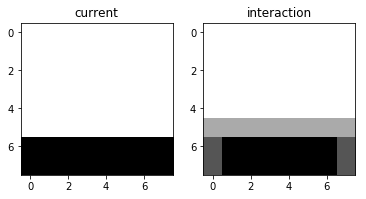

In [8]:
plt.figure()
plt.subplot(121)
plt.title('current')
plt.imshow(proba>=1)
plt.subplot(122)
plt.title('interaction')
plt.imshow(compute_interaction(proba>=1, .5))
plt.show()

Q5: complete the following function to compute one update step of Gibbs sampling.

In [9]:
def one_gibbs_update(unary, current, interaction, reg_strength):
    n_lin = unary.shape[0]
    n_col = unary.shape[1]
    
    i_lin = np.random.randint(n_lin)
    i_col = np.random.randint(n_col)

    proba_emission = 1 / (1 + np.exp(-unary[i_lin, i_col] - interaction[i_lin, i_col]))

    new_value = np.random.rand()< proba_emission
    
    #since we only changed the value of one pixel, we can only update the interatcion teerm of its neighbors 
    diff = new_value - current[i_lin, i_col]
    current[i_lin, i_col] = new_value

    if i_lin > 0 : interaction[i_lin-1, i_col] += 4 * reg_strength * diff
    if i_lin < n_lin - 1 : interaction[i_lin+1, i_col] += 4 * reg_strength * diff
    if i_col > 0 : interaction[i_lin, i_col-1] += 4 * reg_strength * diff 
    if i_col < n_col - 1 : interaction[i_lin, i_col+1] += 4 * reg_strength * diff

In [10]:
#test cell, run it a few times to make sure it doesn't crash

unary = compute_unary(proba, 0.5)
current = (np.random.randint(2, size = proba.shape)).astype('f4')
interaction = compute_interaction(current, 0.5)
for i in range(100):
    one_gibbs_update(unary, current, interaction, 0.5)

Q6: Complete the following function, which performs Gibbs sampling, keep track of the samples $\sum_{t = T_0}^T z_{i}^{(t)}$ and represent the marginals every fifty iterations. Chose a burn in period of $10\%$ of the iterations.

In [11]:
def animate_gibbs_simple(proba, n_ite_gibbs = 1000, reg_strength = 0.5):
    
    n_lin = proba.shape[0]
    n_col = proba.shape[1]
    burn_in = n_ite_gibbs / 10

    global sample_history, current, interaction
    unary = compute_unary(proba, reg_strength)
    current = (np.random.randint(2, size = proba.shape)).astype('f4')
    interaction = compute_interaction(current, reg_strength)
    sample_history = np.zeros_like(proba)
    
    fig = plt.figure()
    plt.title("Burn in") 
    plt.axis('off')
    plt.set_cmap('binary')
    im = plt.imshow(sample_history, animated=True, vmin = 0, vmax = 1)

    def updatefig(i):
        #i is the iteration
        global sample_history, current, interaction
        one_gibbs_update(unary, current, interaction, reg_strength)
        
        if i > burn_in :
            sample_history = sample_history + current

        if i > burn_in and i % 100 == 0 :
            plt.title("Iteration = %d" % (i))
            im.set_array(sample_history/(i-burn_in))
        
        return im,
    
    anim = animation.FuncAnimation(fig, updatefig, interval=1, blit=True, frames = n_ite_gibbs, repeat = False)
    plt.show()
    return anim

Q7: run the following cell a few times. What do you notice from one run to another? Was this expected?

Comment on the convergence speed.

<IPython.core.display.Javascript object>


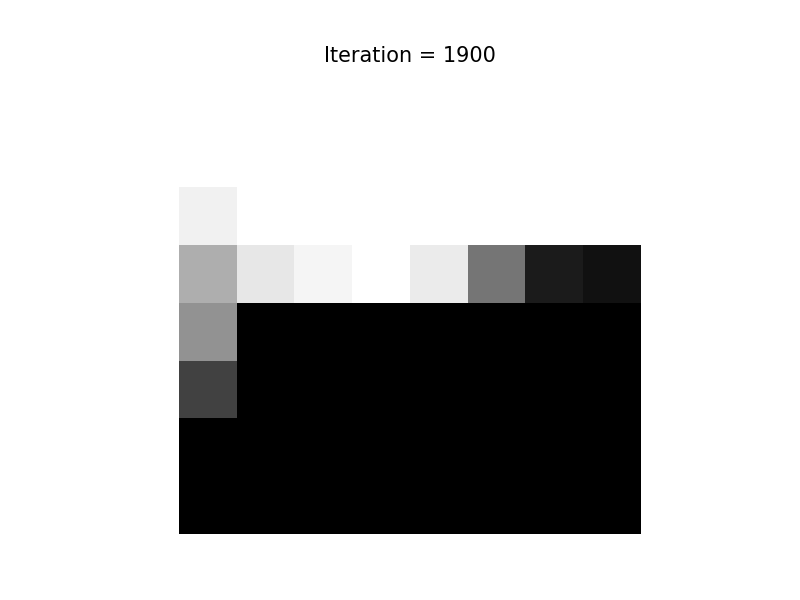

In [13]:
%matplotlib notebook
p = animate_gibbs_simple(proba, reg_strength = 1, n_ite_gibbs = 2000)

very slow, results change from one run to another becaus eof sensitivity to initial conditions.

Q8: We consider a binary checker-like partition of the grid into black $B$ and whites $W$ tiles of a chess board, as represented below. Show that 
$$
p(z_B \mid z^{(t-1)}, x; \eta) =  p(z_B \mid z_W^{(t-1)}, x; \eta),
$$

and symetrically

$$
p(z_W \mid z^{(t-1)}, x; \eta) =  p(z_W \mid z_B^{(t-1)}, x; \eta).
$$

<IPython.core.display.Javascript object>


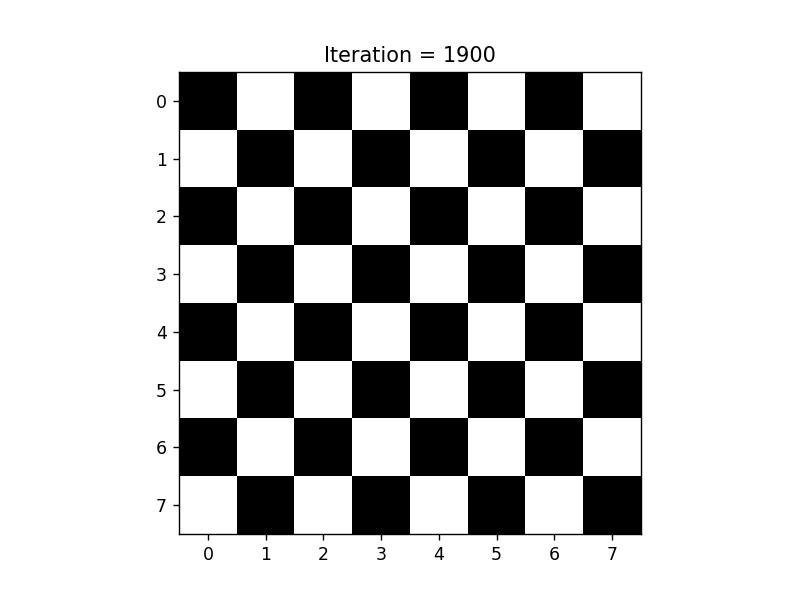

In [23]:
plt.figure()
plt.set_cmap('binary')
coords=np.ogrid[0:8,0:8]
selected_pixel=(coords[0]+coords[1])%2 == 0
plt.imshow(selected_pixel)
plt.show()

the neighbors of all pixels in $W$ are in $B$, and vice versa.

Q9 : As a consequence we can modify the Gibbs algorithm to alternate between sampling all white and black tiles. Complete the follwoing function to implement this. Justify why this should be faster.

In [15]:
def block_gibbs_update(even_ite, unary, current, interaction, reg_strength):
    n_lin = unary.shape[0]
    n_col = unary.shape[1]
    
    coords=np.ogrid[0:n_lin,0:n_col]
    selected_pixel=(coords[0]+coords[1])%2 == even_ite

    proba_emission = 1 / (1 + np.exp(- unary[selected_pixel] - interaction[selected_pixel]))
    new_value = np.random.rand(proba_emission.size)< proba_emission
    current[selected_pixel] = new_value
    interaction[:,:] = compute_interaction(current, reg_strength)

In [16]:
#test cell, run it a few times to make sure it doesn't crash

unary = compute_unary(proba, 0.5)
current = (np.random.randint(2, size = proba.shape)).astype('f4')
interaction = compute_interaction(current, 0.5)
for i in range(100):
    block_gibbs_update(i%2, unary, current, interaction, 0.5)

In [17]:
def animate_gibbs_block(proba, n_ite_gibbs = 1000, reg_strength = 0.1, temperature = 1):
    
    n_lin = proba.shape[0]
    n_col = proba.shape[1]
    burn_in = n_ite_gibbs / 10
    
    print(n_lin,n_col)

    global sample_history, current, interaction
    unary = compute_unary(proba, reg_strength)
    current = (np.random.randint(2, size = proba.shape)).astype('f4')
    interaction = compute_interaction(current, reg_strength)
    sample_history = np.zeros_like(proba)
    
    fig = plt.figure()
    plt.title("Burn in")
    plt.axis("off") 
    im = plt.imshow(sample_history, animated=True, vmin = 0, vmax = 1)

    def updatefig(i):
        global sample_history, current, interaction
        block_gibbs_update(i % 2, unary, current, interaction, reg_strength)
        if i > burn_in :
            sample_history = sample_history + current

        if i > burn_in and i % 20 == 0 :
            plt.title("Iteration = %d" % (i))
            im.set_array(sample_history/(i-burn_in))
        
        return im,
    
    anim = animation.FuncAnimation(fig, updatefig, interval=1, blit=True, frames = n_ite_gibbs, repeat = False)
    plt.show()
    return anim

Q9 : Run Block Gibbs sampling on this larger exemple. It should be much faster.

Try the following value for reg strength and comment:
$$0,0.2,0.5,1,10,-1$$

100 100


<IPython.core.display.Javascript object>


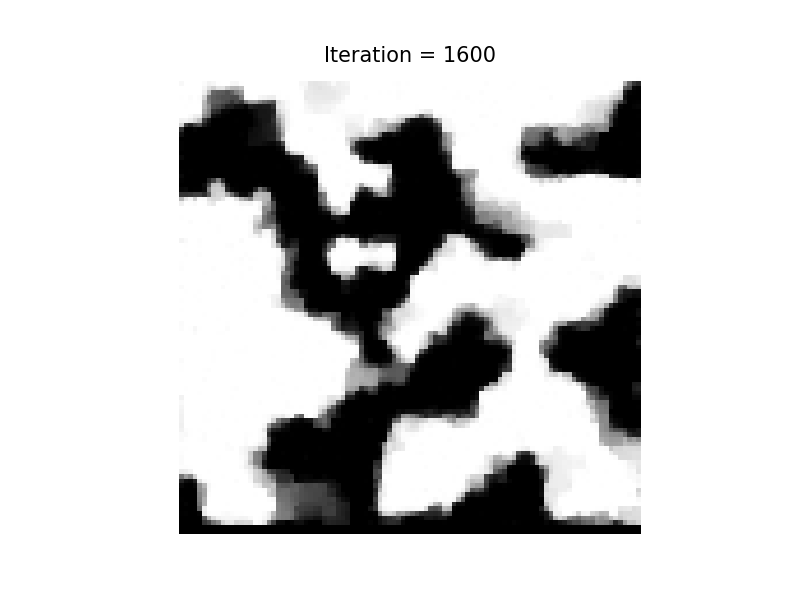

In [33]:
#proba = np.random.rand(100,100)
proba[0:2,:] = 0
proba[-2:,:] = 1
animate_gibbs_block(proba, n_ite_gibbs = 2000, reg_strength = 1)

0 : no increase regularity, visualizing the average of the $q_i$
0.2, 0.5 : some constant patterns start appearing, still no regularity
1 : some black and white regions appearing. Depends highly on intiallization of $q_i$: are area where the random values of $q_i$ were slightly higher or lower than 0.5
10 : same but with coarser patterns. Slower convergence speed. Do not converge to gray because the samling get stuck in some stable configuration.

Q10: We now consider an application to object/background image segmentation. This time the probability comes from a discriminative learning algorithm (random forrest) trained on the RGB values of an image coupled with its ground truth segmentation. The trained algorithm gives for each pixel of a test image a probability score of being in state object/background. Run the following cells to represent this probability, and comment on the resulting probability.

<IPython.core.display.Javascript object>


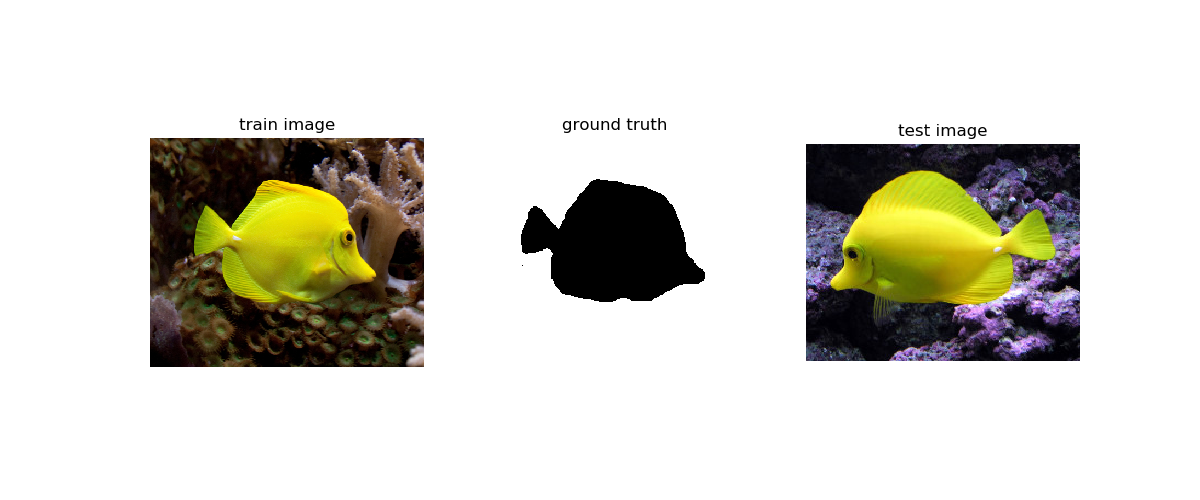

<IPython.core.display.Javascript object>


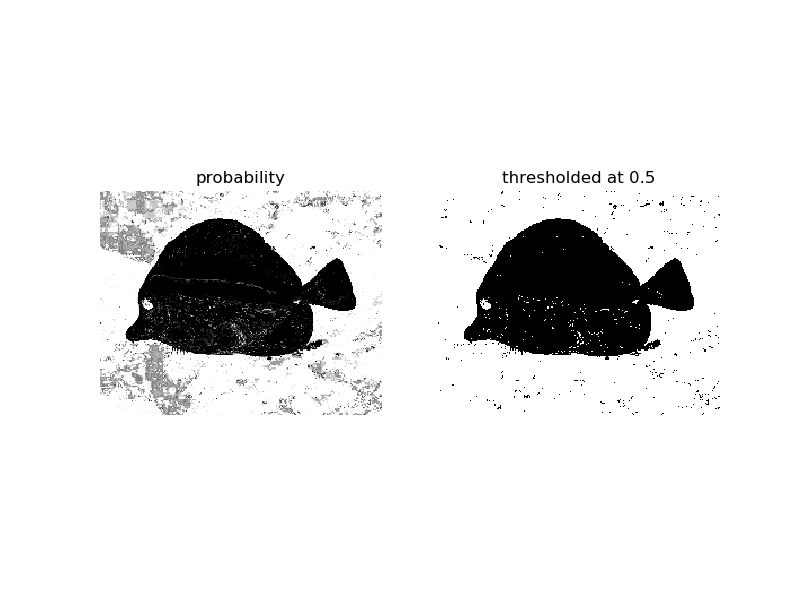

In [24]:
fish_train_rgb = np.asarray(Image.open("fish1.jpg").convert('RGB'))
fish_train_tag_rgb = np.asarray(Image.open("fish1Tag.jpg").convert('RGB'))
fish_train_gt = ((fish_train_tag_rgb).sum(-1) > 200) #white enough
fish_test_rgb = np.asarray(Image.open("fish3.jpeg").convert('RGB'))

fish_train_vec = fish_train_rgb.reshape(-1, fish_train_rgb.shape[-1])
fish_test_vec = fish_test_rgb.reshape(-1, fish_test_rgb.shape[-1])
fish_train_vec_gt = fish_train_gt.flatten()
fish_train_dim = fish_train_rgb.shape[0:2]
fish_test_dim = fish_test_rgb.shape[0:2]

figure(num=None, figsize=(12, 5), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(131)
plt.axis('off')
imshow(fish_train_rgb)
plt.title('train image')
plt.subplot(132)
plt.axis('off')
plt.title('ground truth')
imshow(fish_train_gt)
plt.subplot(133)
plt.axis('off')
plt.title('test image')
imshow(fish_test_rgb)

rfe = RandomForestClassifier(max_depth=None, min_samples_split=2, random_state=0, n_estimators = 10)
rfe.fit(fish_train_vec, fish_train_vec_gt)
fish_proba = rfe.predict_proba(fish_test_vec)[:,1]
fish_proba = fish_proba.reshape((fish_test_dim))
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.axis('off')
plt.title('probability')
imshow(fish_proba)
plt.subplot(122)
plt.axis('off')
plt.title('thresholded at 0.5')
imshow(fish_proba>0.5)

does a decent job, but as it only consider pixels one at a time has no spatia regularity

Q11: Run Block gibbs sampling on the object probability given by the random forrest. Find an appropriate regularization strength.

198 250


<IPython.core.display.Javascript object>


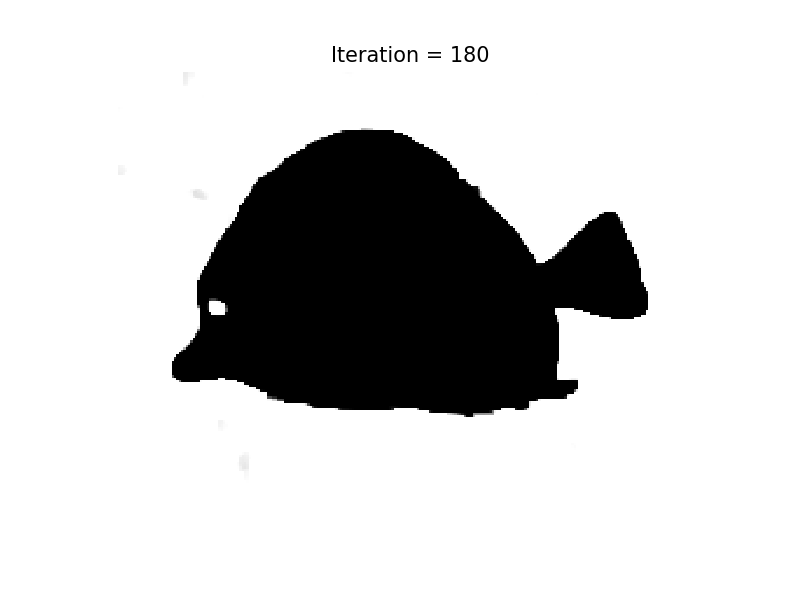

In [25]:
animate_gibbs_block(fish_proba , n_ite_gibbs = 200, reg_strength = 10)

high values of $\lambda$ are good. The eye remain miscalssified as it is large enough to sustain itself, and circular (low perimeter compared to surface = less interaction).

Note: try some absurd values (1e20) for some surprising result. Why is that?

Note that Gibbs sampling is NOT an efficient method of object segmentation. This exercice is an illustration of the method.
Object segmentation amounts to compute the MAP of this problem, which can be efficienctly computed using max-flow formulations as long as the interactions are attractives.